# LSTM - Long Short Term Memory

http://data.is/1bKs2mG 

International airline passengers: monthly totals in thousands. Jan 49 – Dec 60

After https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
from conx import Network, Layer, LSTMLayer, plot, frange

Using Theano backend.
conx, version 3.5.5


For this experiment, we will use the monthly counts of international airline passengers on tickets between 1949 and 1961, in thousands:

In [2]:
data = [112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 
        126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150, 
        178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193, 
        181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235, 
        229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234, 
        264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315, 
        364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413, 
        405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467, 
        404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404, 
        359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 
        362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 
        432]

Plotting the data shows a regular, but varying, cyclic pattern:

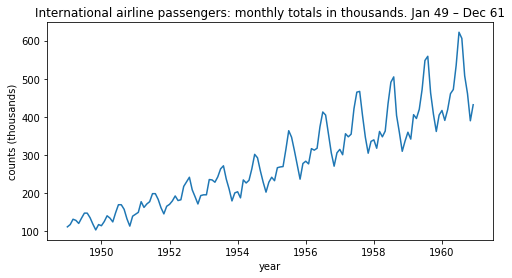

In [3]:
plot(["", data], 
     title="International airline passengers: monthly totals in thousands. Jan 49 – Dec 61",
     xlabel="year", 
     ylabel="counts (thousands)",
    xs=[x for x in frange(1949, 1961, 1/12)])

Let's scale the counts into the range 0 - 1:

In [4]:
def scale(data):
    """
    Scale data to between 0 and 1
    """
    minv = min(data)
    maxv = max(data)
    span = maxv - minv
    return [(v - minv)/span for v in data]

In [5]:
scaled_data = scale(data)

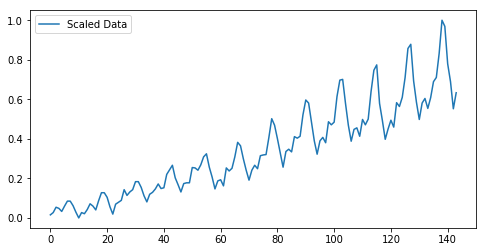

In [6]:
plot(["Scaled Data", scaled_data])

For our dataset, we will contruct a history sequence. First, we need to put each scaled value into a list. This is the list of *features*. In our case, we just have the one feature:

In [7]:
sequence = [[datum] for datum in scaled_data]

We wish that the inputs -> targets are constructed as follows:

1. [S0] -> S1
2. [S1] -> S2
3. ...

where Sn is a list of features in the sequence.

We need to inform the network of the shape of the sequence. We need the:

* time_steps - the length of the history
* batch_size - how many vectors are the inputs composed of?
* features - the length of each input bank vector

In [8]:
time_steps = 1  # history
batch_size = 1  # how many to load at once
features = 1    # features (length of input vector)

In [9]:
def create_dataset(sequence, time_steps):
    dataset = []
    for i in range(len(sequence)-time_steps-1):
        dataset.append([sequence[i:(i+time_steps)], 
                       sequence[i + time_steps]])
    return dataset

In [10]:
dataset = create_dataset(sequence, time_steps)

In [11]:
print(dataset[0])
print(dataset[1])

[[[0.015444015444015444]], [0.02702702702702703]]
[[[0.02702702702702703]], [0.05405405405405406]]


Now we construct the network giving the batch_shape in terms of (look_back, banks, width):

In [12]:
net = Network("LSTM")
net.add(Layer("input", features, batch_shape=(batch_size, time_steps, features)))
net.add(LSTMLayer("lstm", 4)) 
net.add(Layer("output", 1))
net.connect()
net.compile(error="mse", optimizer="adam")

In [13]:
net.dataset.load(dataset)

In [14]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('input', 'lstm', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

In [15]:
net.dataset.split(.33)

In [16]:
net.propagate([[.02]])

[-0.000337743986165151]

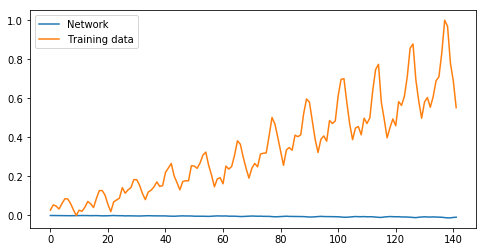

In [17]:
outputs = [net.propagate(i) for i in net.dataset.inputs]
plot([["Network", outputs], ["Training data", net.dataset.targets]])

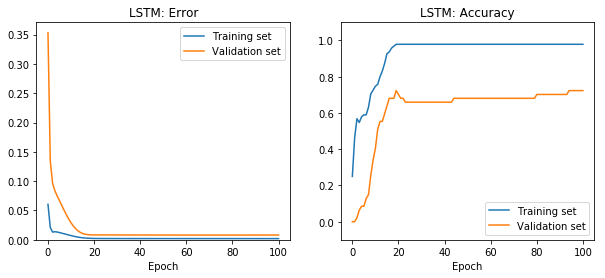

In [18]:
if net.saved():
    net.load()
    net.plot_loss_acc()
else:
    net.train(100, batch_size=batch_size, shuffle=False, plot=True, save=True)

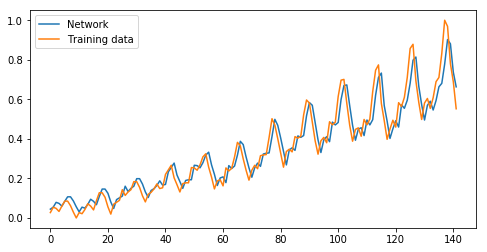

In [20]:
outputs = [net.propagate(i) for i in net.dataset.inputs]
plot([["Network output", outputs], ["Training data", net.dataset.targets]])

**NOTE**: Even though the above plot of the Network output appears to closely track the Training data, don't be fooled! As can be seen in the accuracy plot after training, the trained network has about 70% accuracy. Why does it look so good in the plot? Take a moment to consider how it can look so good, and yet be so bad.

# LSTM with Window

In [21]:
time_steps = 3

In [22]:
dataset = create_dataset(sequence, time_steps)

In [23]:
print(dataset[0])
print(dataset[1])

[[[0.015444015444015444], [0.02702702702702703], [0.05405405405405406]], [0.04826254826254826]]
[[[0.02702702702702703], [0.05405405405405406], [0.04826254826254826]], [0.032818532818532815]]


In [24]:
net2 = Network("LSTM with Window")
net2.add(Layer("input", features, batch_shape=(batch_size, time_steps, features)))
net2.add(LSTMLayer("lstm", 4)) 
net2.add(Layer("output", 1))
net2.connect()
net2.compile(error="mse", optimizer="adam")

In [25]:
net2.dataset.load(dataset)
net2.dataset.split(.33)

<IPython.core.display.Javascript object>

<Network name='LSTM with Window' (compiled)>
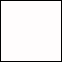
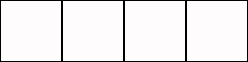
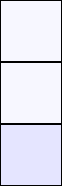

In [26]:
net2

In [27]:
net2.propagate([[0.1], [0.2], [0.3]])

[0.010807438753545284]

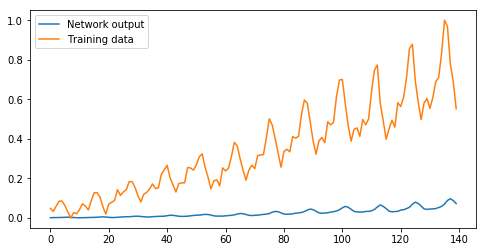

In [29]:
outputs = [net2.propagate(i) for i in net2.dataset.inputs]
plot([["Network output", outputs], ["Training data", net2.dataset.targets]])

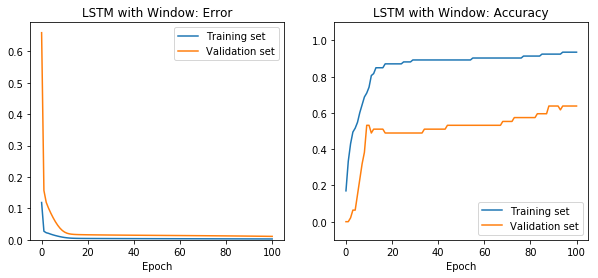

In [30]:
if net2.saved():
    net2.load()
    net2.plot_loss_acc()
else:
    net2.train(100, batch_size=batch_size, shuffle=False, plot=True, save=True)

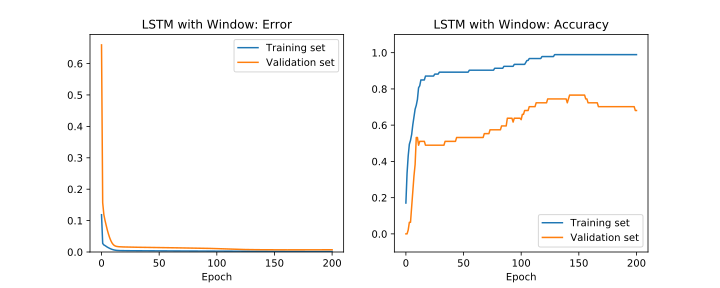

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#  200 |   0.00173 |   0.98925 |   0.00713 |   0.68085 
Saving network... Saved!


In [31]:
net2.train(100, batch_size=batch_size, shuffle=False, plot=True, save=True)

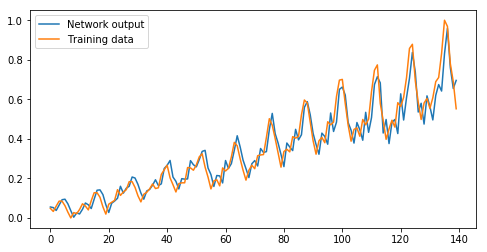

In [33]:
outputs = [net2.propagate(i) for i in net2.dataset.inputs]
plot([["Network output", outputs], ["Training data", net2.dataset.targets]])

## LSTM with State

In [34]:
net3 = Network("LSTM with Window and State")
net3.add(Layer("input", features, batch_shape=(batch_size, time_steps, features)))
net3.add(LSTMLayer("lstm", 4, stateful=True)) 
net3.add(Layer("output", 1))
net3.connect()
net3.compile(error="mse", optimizer="adam")

In [35]:
net3.dataset.load(dataset)
net3.dataset.split(.33)

<IPython.core.display.Javascript object>

<Network name='LSTM with Window' (compiled)>
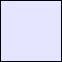
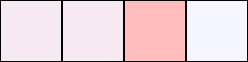
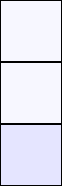

In [36]:
net2

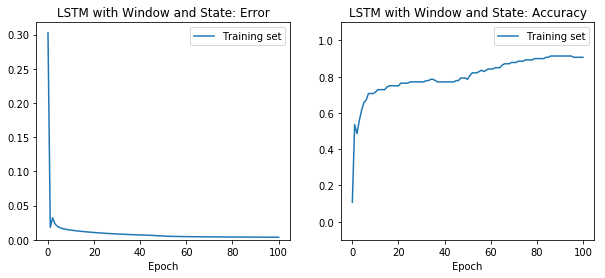

In [37]:
if net3.saved():
    net3.load()
    net3.plot_loss_acc()
else:
    net3.train(100, batch_size=batch_size, shuffle=False, plot=True, save=True)

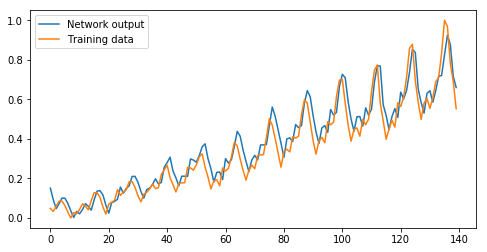

In [39]:
outputs = [net3.propagate(i) for i in net3.dataset.inputs]
plot([["Network output", outputs], ["Training data", net3.dataset.targets]])

## LSTM - Stacked

In [40]:
net4 = Network("LSTM with Window and State and Stacked")
net4.add(Layer("input", features, batch_shape=(batch_size, time_steps, features)))
net4.add(LSTMLayer("lstm-1", 4, stateful=True, return_sequences=True)) 
net4.add(LSTMLayer("lstm-2", 4, stateful=True)) 
net4.add(Layer("output", 1))
net4.connect()
net4.compile(error="mse", optimizer="adam")

In [41]:
net4.dataset.load(dataset)
net4.dataset.split(.33)

<IPython.core.display.Javascript object>

<Network name='LSTM with Window and State and Stacked' (compiled)>
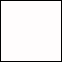
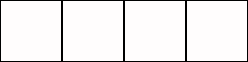
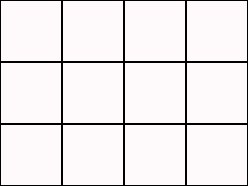
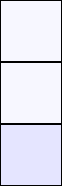

In [42]:
net4

In [43]:
net4.propagate([[0.1], [-0.2], [0.8]])

[0.0064370655454695225]

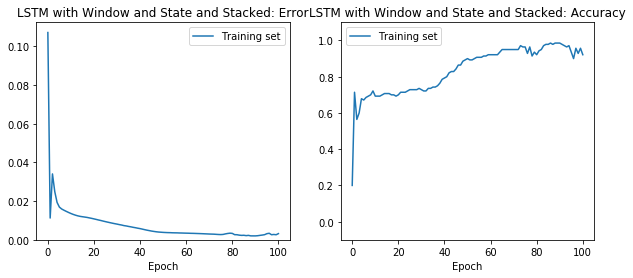

In [44]:
if net4.saved():
    net4.load()
    net4.plot_loss_acc()
else:
    net4.train(100, batch_size=batch_size, shuffle=False, plot=True, save=True)

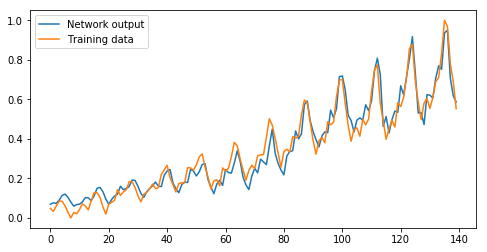

In [45]:
outputs = [net4.propagate(i) for i in net4.dataset.inputs]
plot([["Network output", outputs], ["Training data", net4.dataset.targets]])